## Import modules

In [1]:
import random
from collections import deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Set random seed

In [2]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Network
We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [3]:
from torch.distributions import Categorical


class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden = nn.Linear(in_dim, 32)
        self.out = nn.Linear(32, out_dim)

        self.hidden.weight.data.uniform_(-3e-3, 3e-3)
        self.hidden.bias.data.uniform_(-3e-3, 3e-3)
        self.out.weight.data.uniform_(-3e-3, 3e-3)
        self.out.bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))

        logits = self.out(x)
        dist = Categorical(logits=logits)
        action = dist.sample()

        return action, dist


class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 64)
        self.out = nn.Linear(64, 1)

        self.hidden.weight.data.uniform_(-3e-3, 3e-3)
        self.hidden.bias.data.uniform_(-3e-3, 3e-3)
        self.out.weight.data.uniform_(-3e-3, 3e-3)
        self.out.bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

## GAE

*GAE* help to reduce variance while maintaining a proper level of bias. By adjusting parameters $\lambda \in [0, 1]$ and $\gamma \in [0, 1]$. Please see [the paper](https://arxiv.org/pdf/1506.02438) for detailed description.

In [4]:
def compute_gae(
    next_value: list, 
    rewards: list, 
    masks: list, 
    values: list, 
    gamma: float, 
    tau: float
) -> list:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = (
            rewards[step]
            + gamma * values[step + 1] * masks[step]
            - values[step]
        )
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])

    return list(returns)

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


PPO updates the model several times(`epoch`) using the stacked memory. By `iter` function, It yield the samples of stacked memory by interacting a environment.

In [5]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)  # 2048
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):  # mini_batch_size = 64
            rand_ids = np.random.choice(batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids], values[
                rand_ids
            ], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]

In [6]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
        device: torch.device = torch.device("cpu"),
    ):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight

        self.device = device
        print(self.device)

        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)

        # memory for training
        self.states: list[torch.Tensor] = []
        self.actions: list[torch.Tensor] = []
        self.rewards: list[torch.Tensor] = []
        self.values: list[torch.Tensor] = []
        self.masks: list[torch.Tensor] = []
        self.log_probs: list[torch.Tensor] = []

        # total steps count
        self.total_step = 1

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.probs.argmax() if self.is_test else action

        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))

        return selected_action.cpu().detach().numpy()

    def step(self, action: np.ndarray) -> tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""

        next_state, reward, done, truncated, info = self.env.step(action.item())
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def update_model(
        self, next_state: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)

        returns = compute_gae(
            next_value,
            self.rewards,
            self.masks,
            self.values,
            self.gamma,
            self.tau,
        )
        states = torch.cat(self.states).view(-1, 4)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []

        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            epoch=self.epoch,
            mini_batch_size=self.batch_size,
            states=states,
            actions=actions,
            values=values,
            log_probs=log_probs,
            returns=returns,
            advantages=advantages,
        ):
            # calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()

            # actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = (
                torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv
            )

            # entropy
            entropy = dist.entropy().mean()

            actor_loss = (
                -torch.min(surr_loss, clipped_surr_loss).mean()
                - entropy * self.entropy_weight
            )

            # critic_loss
            value = self.critic(state)
            # clipped_value = old_value + (value - old_value).clamp(-0.5, 0.5)
            critic_loss = (return_ - value).pow(2).mean()

            # train critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)

        return actor_loss, critic_loss

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, info = self.env.reset()
        state = np.expand_dims(state, axis=0)

        actor_losses, critic_losses = [], []
        scores = []
        score = 0

        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward[0][0]

                # if episode ends
                if done[0][0]:
                    state, info = env.reset()
                    state = np.expand_dims(state, axis=0)
                    scores.append(score)
                    score = 0

                    self._plot(self.total_step, scores, actor_losses, critic_losses)

            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # termination
        self.env.close()

    def test(self, video_folder: str, num_frames: int = 1000) -> None:
        """Test the agent."""
        self.is_test = True

        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(
            self.env, video_folder=video_folder, name_prefix="ppo-CartPole-v1"
        )

        state, info = self.env.reset()
        done = False
        score = 0

        total_step = 0

        while True:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            total_step += 1

            if done or total_step > num_frames:
                break

        print("score: ", score)
        self.env.close()

        # reset
        self.env = naive_env

    def _plot(
        self,
        frame_idx: int,
        scores: list[float],
        actor_losses: list[float],
        critic_losses: list[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: list[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [7]:
env_id = "CartPole-v1"
env = gym.make(env_id, render_mode="rgb_array")

## Initialize

In [8]:
num_frames = 100000
agent = PPOAgent(
    env,
    gamma=0.9,
    tau=0.8,
    batch_size=64,
    epsilon=0.2,
    epoch=64,
    rollout_len=2048,
    entropy_weight=0.005,
    device=torch.device("cpu"),
)

cpu


## Train

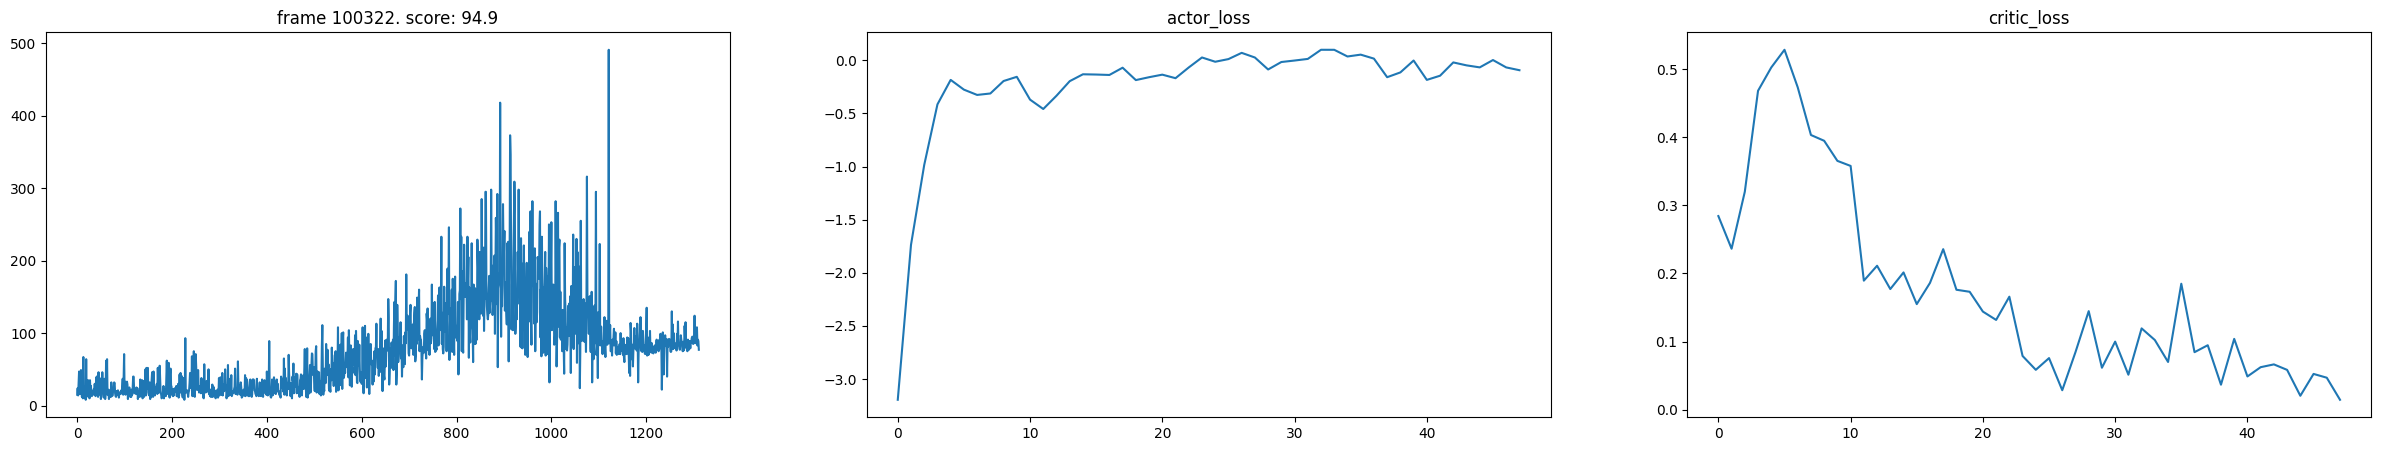

In [9]:
agent.train(num_frames)

In [10]:
video_folder="videos/ppo_cartpole"
agent.test(video_folder=video_folder, num_frames=10000)

Moviepy - Building video /home/tk/repos/pg-is-all-you-need/videos/ppo_cartpole/ppo-CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/tk/repos/pg-is-all-you-need/videos/ppo_cartpole/ppo-CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/tk/repos/pg-is-all-you-need/videos/ppo_cartpole/ppo-CartPole-v1-episode-0.mp4
score:  [[87.]]


In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/ppo_cartpole/ppo-CartPole-v1-episode-0.mp4
